In [1]:
import pandas as pd 
import glob 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


In [2]:
files = glob.glob("J:/OneDrive/Documents/Personal Files/Academic/Demokritos/Big Data Security and Visualization/Assignments/Security/Bot-IOT/Dataset/*.csv")

li = []

for filename in files:
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

J:/OneDrive/Documents/Personal Files/Academic/Demokritos/Big Data Security and Visualization/Assignments/Security/Bot-IOT/Dataset\UNSW_2018_IoT_Botnet_Full5pc_1.csv


C:\Users\george.apostolakis\AppData\Local\Temp\ipykernel_27560\1293383071.py:7: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, index_col=None, header=0)


J:/OneDrive/Documents/Personal Files/Academic/Demokritos/Big Data Security and Visualization/Assignments/Security/Bot-IOT/Dataset\UNSW_2018_IoT_Botnet_Full5pc_2.csv


C:\Users\george.apostolakis\AppData\Local\Temp\ipykernel_27560\1293383071.py:7: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, index_col=None, header=0)


J:/OneDrive/Documents/Personal Files/Academic/Demokritos/Big Data Security and Visualization/Assignments/Security/Bot-IOT/Dataset\UNSW_2018_IoT_Botnet_Full5pc_3.csv


C:\Users\george.apostolakis\AppData\Local\Temp\ipykernel_27560\1293383071.py:7: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, index_col=None, header=0)


J:/OneDrive/Documents/Personal Files/Academic/Demokritos/Big Data Security and Visualization/Assignments/Security/Bot-IOT/Dataset\UNSW_2018_IoT_Botnet_Full5pc_4.csv


C:\Users\george.apostolakis\AppData\Local\Temp\ipykernel_27560\1293383071.py:7: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, index_col=None, header=0)


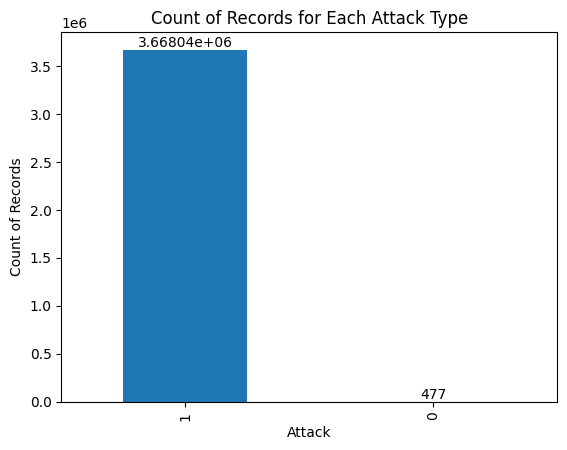

In [3]:
attack_counts = df['attack'].value_counts()
ax = attack_counts.plot(kind='bar')
plt.xlabel('Attack')
plt.ylabel('Count of Records')
plt.title('Count of Records for Each Attack Type')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

In [4]:
df_cleaned = df.drop(columns = ['pkSeqID','stime','flgs','proto','saddr','daddr','state','ltime','seq','category','subcategory'])

In [5]:
df_final = df_cleaned[df_cleaned['attack']==0]

In [6]:
df_cleaned = df_cleaned[df_cleaned['attack'] != 0]
df_cleaned.reset_index(drop=True, inplace=True)


In [7]:
frames = [df_final, df_cleaned.head(10000)]
df_final = pd.concat(frames, ignore_index=True)

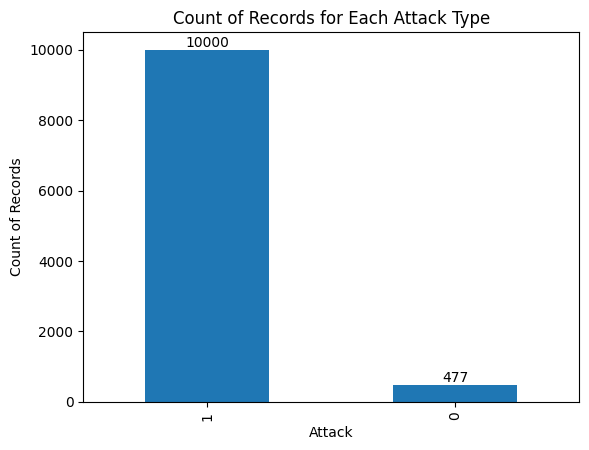

In [8]:
attack_counts = df_final['attack'].value_counts()
ax = attack_counts.plot(kind='bar')
plt.xlabel('Attack')
plt.ylabel('Count of Records')
plt.title('Count of Records for Each Attack Type')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

In [9]:
def convert_hex_to_decimal(value):
    if isinstance(value, str) and value.startswith('0x'):
        try:
            return int(value, 16)
        except ValueError:
            pass
    return value

In [24]:
df_final['sport'] = df_final['sport'].apply(convert_hex_to_decimal).astype(int)
df_final['dport'] = df_final['dport'].apply(convert_hex_to_decimal).astype(int)

In [26]:
X = df_final.drop(columns=['attack'])
y = df_final['attack']

In [29]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Split the training set into train (90%) and validation (10%) sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [33]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_final)

In [44]:
from collections import Counter
print(f'Class counts before SMOTE: {Counter(y_train_final)}')
print(f'Class counts after SMOTE: {Counter(y_train_smote)}')

Class counts before SMOTE: Counter({1: 7198, 0: 344})
Class counts after SMOTE: Counter({1: 7198, 0: 7198})


In [16]:
svm = SVC(kernel='linear')

In [17]:
# Initialize RFE with the SVM estimator and desired number of features
rfe = RFE(estimator=svm, n_features_to_select=10)

# Fit RFE
rfe.fit(X_train_smote, y_train_smote)

RFE(estimator=SVC(kernel='linear'), n_features_to_select=10)

In [18]:
# Transform the datasets using the fitted RFE
X_train_rfe = rfe.transform(X_train_smote)
X_val_rfe = rfe.transform(X_val)
X_test_rfe = rfe.transform(X_test)

In [19]:
# Get the feature rankings and scores
feature_ranking = rfe.ranking_
feature_scores = rfe.estimator_.coef_[0]

# Create a DataFrame to store feature names, rankings, and scores
features_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_ranking})
# Sort the DataFrame by score in descending order
features_df = features_df.sort_values(by='Ranking', ascending=True)

# Print the ordered features
print("Features ordered by their Ranking:")
print(features_df)

Features ordered by their Ranking:
                             Feature  Ranking
0                        flgs_number        1
1                       proto_number        1
2                              sport        1
28                 N_IN_Conn_P_DstIP        1
5                              bytes        1
6                       state_number        1
7                                dur        1
8                               mean        1
24                      TnP_PerProto        1
11                               min        1
17                              rate        2
31                AR_P_Proto_P_Dport        3
16                            dbytes        4
30                AR_P_Proto_P_Sport        5
12                               max        6
32  Pkts_P_State_P_Protocol_P_DestIP        7
29                 N_IN_Conn_P_SrcIP        8
14                             dpkts        9
3                              dport       10
4                               pkts       11

In [20]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize Stratified K-Fold
cv = StratifiedKFold(n_splits=10)

# Initialize GridSearchCV with SVM, parameter grid, and stratified K-Fold
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=cv)

# Fit GridSearchCV
grid.fit(X_train_rfe, y_train_smote)

# Best estimator after grid search
best_model = grid.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0

In [21]:
# Predictions on validation set
y_val_pred = best_model.predict(X_val_rfe)
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00       801

    accuracy                           1.00       839
   macro avg       0.99      1.00      0.99       839
weighted avg       1.00      1.00      1.00       839



In [22]:
# Precision, recall, accuracy, and F1 score on validation set
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Precision: 1.0
Recall: 0.9987515605493134
Accuracy: 0.99880810488677
F1 Score: 0.9993753903810119


In [23]:
# Predictions on test set
y_test_pred = best_model.predict(X_test_rfe)
print("Test Set Evaluation")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      1.00      1.00      2001

    accuracy                           1.00      2096
   macro avg       0.99      1.00      0.99      2096
weighted avg       1.00      1.00      1.00      2096



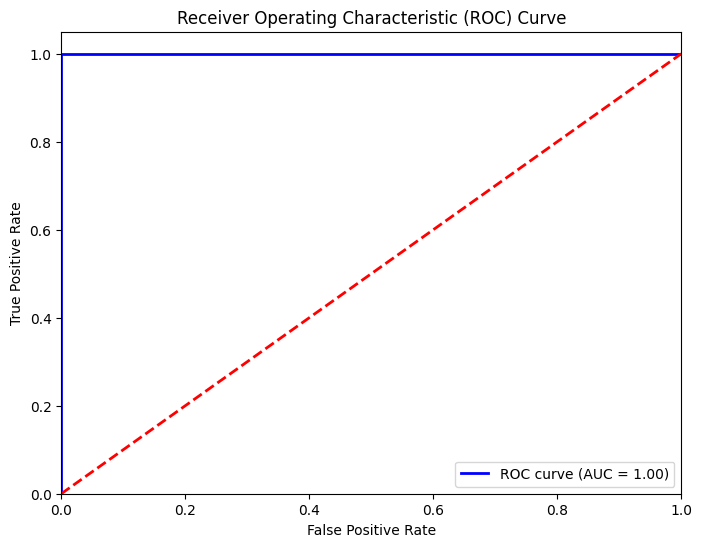

In [24]:
# ROC curve
y_test_score = best_model.decision_function(X_test_rfe)
fpr, tpr, thresholds = roc_curve(y_test, y_test_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

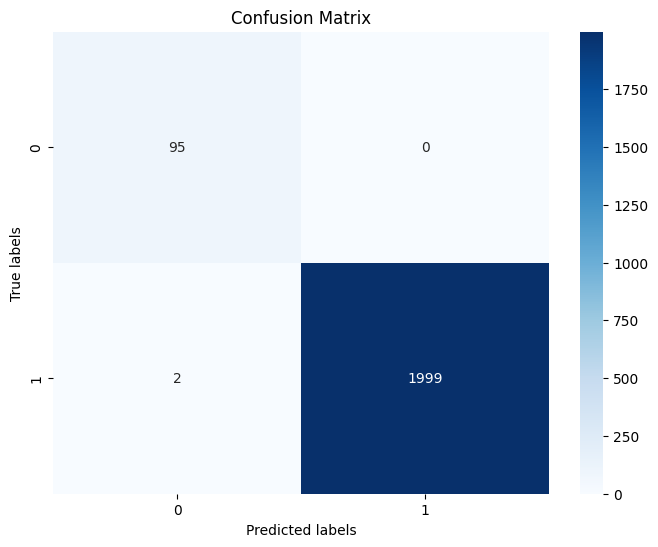

In [25]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()